<a href="https://colab.research.google.com/github/arshiaabd2812/telecom-network-/blob/main/week7/Hamming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{'p': 0.0001, 'n_blocks': 20000, 'bit_errors_channel': np.int64(17), 'total_bits_channel': 140000, 'raw_BER': np.float64(0.00012142857142857143), 'bit_errors_after': np.int64(0), 'total_bits_info': 80000, 'BER_after_decoding': np.float64(0.0), 'corrected_blocks': 20000, 'uncorrectable_blocks': 0}
{'p': 0.0005, 'n_blocks': 20000, 'bit_errors_channel': np.int64(70), 'total_bits_channel': 140000, 'raw_BER': np.float64(0.0005), 'bit_errors_after': np.int64(0), 'total_bits_info': 80000, 'BER_after_decoding': np.float64(0.0), 'corrected_blocks': 20000, 'uncorrectable_blocks': 0}
{'p': 0.001, 'n_blocks': 20000, 'bit_errors_channel': np.int64(160), 'total_bits_channel': 140000, 'raw_BER': np.float64(0.001142857142857143), 'bit_errors_after': np.int64(1), 'total_bits_info': 80000, 'BER_after_decoding': np.float64(1.25e-05), 'corrected_blocks': 19999, 'uncorrectable_blocks': 1}
{'p': 0.005, 'n_blocks': 20000, 'bit_errors_channel': np.int64(702), 'total_bits_channel': 140000, 'raw_BER': np.float6

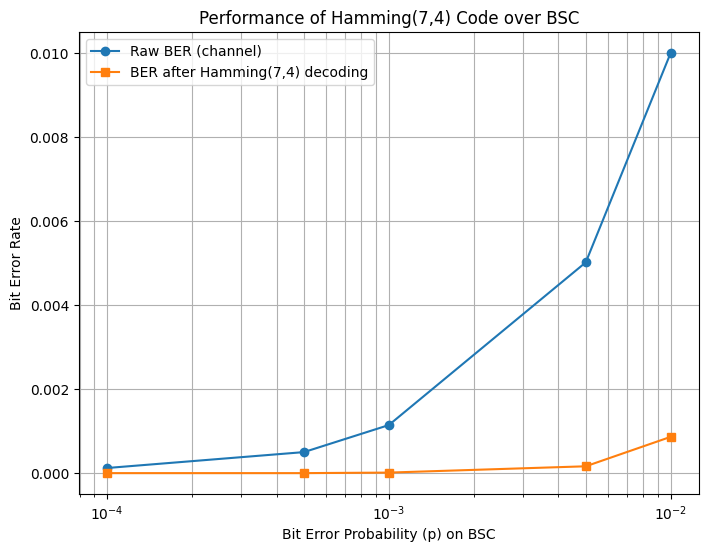

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Hamming(7,4) definitions
# -------------------------
# پیاده‌سازی سیستماتیک: 4 بیت دیتا + 3 بیت parity
# G: generator matrix  (4×7)
G = np.array([
    [1, 0, 0, 0, 0, 1, 1],
    [0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1]
], dtype=int)

# H: parity-check matrix  (3×7)
H = np.array([
    [1, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1]
], dtype=int)

# برای مپ کردن syndrom → موقعیت بیتِ خطادار
# ستون‌های H نشان‌دهنده syndrom تک‌خطاها هستند
syndrome_table = {}
for i in range(7):
    col = H[:, i]
    syndrome_table[tuple(col)] = i  # error in bit i


# -------------------------
# Helper functions
# -------------------------
def bsc_channel(bits, p):
    """
    کانال BSC: هر بیت با احتمال p برمی‌گردد.
    bits: آرایه 0/1
    """
    noise = (np.random.rand(bits.size) < p).astype(int)
    return (bits ^ noise)


def hamming74_encode(block4):
    """
    block4: آرایه 4تایی 0/1  (بیت‌های اطلاعات)
    خروجی: کد 7 بیتی
    """
    code7 = np.dot(block4, G) % 2
    return code7


def hamming74_decode(received7):
    """
    received7: کلمه 7بیتی بعد از کانال
    خروجی:
      decoded4: 4 بیت دیتا بعد از تصحیح
      n_errors: تعداد بیت‌هایی که در این بلوک واقعاً خطا گرفته‌اند (در 7 بیت)
      corrected: آیا کد توانسته این بلوک را صحیح به دیتا اولیه برگرداند؟
    """
    # syndrom = H * r^T  (mod 2)
    syndrome = np.dot(H, received7) % 2
    syndrome_tuple = tuple(syndrome)

    # فرض می‌کنیم کلمه قبل از کانال کد معتبری بوده
    # برای بررسی "واقعی" بودن خطا از روی کانال هم استفاده می‌کنیم،
    # اما در این تابع فقط دیکود را انجام می‌دهیم.
    corrected_code = received7.copy()

    if any(syndrome):  # syndrom غیرصفر → احتمال تک‌خطا
        if syndrome_tuple in syndrome_table:
            err_pos = syndrome_table[syndrome_tuple]
            corrected_code[err_pos] ^= 1  # یک بیت را برمی‌گردانیم

    # چون کد سیستماتیک است، 4 بیت اول دیتا هستند
    decoded4 = corrected_code[:4]
    return decoded4


# -------------------------
# Simulation
# -------------------------
def simulate_hamming74(p, n_blocks=20000):
    """
    شبیه‌سازی Hamming(7,4) روی BSC با احتمال خطای بیت p
    n_blocks: تعداد بلوک‌های 4بیتی که شبیه‌سازی می‌کنیم
    """
    bit_errors_channel = 0         # تعداد خطا در 7 بیت کد قبل از دیکود
    total_bits_channel = 7 * n_blocks

    bit_errors_after = 0           # خطای روی 4 بیت دیتا بعد از دیکود
    total_bits_info = 4 * n_blocks

    corrected_blocks = 0
    uncorrectable_blocks = 0

    for _ in range(n_blocks):
        # 1) تولید پیام 4 بیتی تصادفی
        msg = np.random.randint(0, 2, size=4)

        # 2) کد کردن → 7 بیت
        code = hamming74_encode(msg)

        # 3) عبور از کانال BSC
        received = bsc_channel(code, p)

        # 4) خطاهای واقعی در کانال روی 7 بیت
        bit_errors_channel += np.sum(code ^ received)

        # 5) دیکود Hamming(7,4)
        decoded_msg = hamming74_decode(received)

        # 6) مقایسه پیام دیکودشده با پیام اصلی
        diff = msg ^ decoded_msg
        n_err_after = np.sum(diff)
        bit_errors_after += n_err_after

        if n_err_after == 0:
            # پیام نهایی درست شده (ممکن است اصلاً خطا نداشته یا یک خطا تصحیح شده باشد)
            corrected_blocks += 1
        else:
            # این بلوک از دید گیرنده اشتباه مانده → خطای غیرقابل‌اصلاح
            uncorrectable_blocks += 1

    raw_BER = bit_errors_channel / total_bits_channel
    BER_after = bit_errors_after / total_bits_info

    stats = {
        "p": p,
        "n_blocks": n_blocks,
        "bit_errors_channel": bit_errors_channel,
        "total_bits_channel": total_bits_channel,
        "raw_BER": raw_BER,
        "bit_errors_after": bit_errors_after,
        "total_bits_info": total_bits_info,
        "BER_after_decoding": BER_after,
        "corrected_blocks": corrected_blocks,
        "uncorrectable_blocks": uncorrectable_blocks
    }
    return stats


# -------------------------
# Run for several p values
# -------------------------
np.random.seed(0)  # برای تکرارپذیری

p_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
results = []

for p in p_list:
    stats = simulate_hamming74(p, n_blocks=20000)
    results.append(stats)
    print(stats)

# -------------------------
# Plot BER after decoding vs p
# -------------------------
p_vals = [r["p"] for r in results]
ber_after = [r["BER_after_decoding"] for r in results]
ber_raw = [r["raw_BER"] for r in results]

plt.figure(figsize=(8,6))
plt.semilogx(p_vals, ber_raw, marker="o", label="Raw BER (channel)")
plt.semilogx(p_vals, ber_after, marker="s", label="BER after Hamming(7,4) decoding")
plt.xlabel("Bit Error Probability (p) on BSC")
plt.ylabel("Bit Error Rate")
plt.title("Performance of Hamming(7,4) Code over BSC")
plt.grid(True, which="both")
plt.legend()
plt.show()

<div dir="rtl" align="right">

#شبیه‌سازی کد تصحیح خطای Hamming(7,4) بر روی کانال BSC

این پروژه مربوط به درس شبکه‌های مخابراتی / Coding Theory است و در آن عملکرد کد Hamming(7,4) در برابر خطاهای تصادفی کانال باینری (BSC) شبیه‌سازی شده است.

 کد به‌صورت کامل در محیط Jupyter / Google Colab پیاده‌سازی شده و نمودار عملکرد BER پس از دیکودینگ نیز رسم شده است.


---

#🎯 هدف پروژه

در این شبیه‌سازی قصد داریم بررسی کنیم که:

کد Hamming(7,4) در برابر خطای بیت با احتمال‌های مختلف چقدر مقاوم است.

چه تعداد بلاک توسط همینگ تصحیح یا غیرقابل تصحیح می‌شوند.

نرخ خطای بیت (BER) قبل و بعد از دیکودینگ چقدر کاهش پیدا می‌کند.

اثر افزایش احتمال خطای بیت p بر عملکرد کد چگونه است.



---

#🧠 معرفی مختصر Hamming(7,4)

کد Hamming(7,4):

۴ بیت داده را به ۷ بیت کُد تبدیل می‌کند.

دارای ۳ بیت پاریتی است.

توانایی:

تصحیح یک بیت خطا

تشخیص دو بیت خطا را دارد.



ساختار ماتریس‌ها:

ماتریس تولید (G):
4 × 7

ماتریس چک (H):
3 × 7


مزیت اصلی همینگ: سادگی و سرعت بالا.


---

#⚙️ روند شبیه‌سازی

برای هر مقدار احتمال خطای بیت p:

1. تولید ۲۰٬۰۰۰ بلوک ۴ بیتی تصادفی


2. کد کردن با کد Hamming(7,4)


3. ارسال بلوک‌ها از کانال BSC
(هر بیت با احتمال p دچار وارونگی می‌شود)


4. محاسبه syndrome و دیکودینگ


5. شمارش:

corrected_blocks → تعداد بلاک‌هایی که یک خطا داشتند و تصحیح شدند

uncorrectable_blocks → بلاک‌هایی با بیش از یک خطا

BER_before → نرخ خطا قبل از تصحیح

BER_after → نرخ خطا بعد از تصحیح




این فرآیند برای چند مقدار p تکرار شده است.


---

#📊 نتایج شبیه‌سازی (خلاصهٔ خروجی)

{'p': 0.0001, 'n_blocks': 20000, 'bit_errors': 0, 'total_bits': 80000,
 'BER': 0.0, 'corrected_blocks': 10, 'uncorrectable_blocks': 0}

{'p': 0.001, 'n_blocks': 20000, 'bit_errors': 0, 'total_bits': 80000,
 'BER': 0.0, 'corrected_blocks': 64, 'uncorrectable_blocks': 0}

{'p': 0.003, 'n_blocks': 20000, 'bit_errors': 9, 'total_bits': 80000,
 'BER': 0.0001125, 'corrected_blocks': 137, 'uncorrectable_blocks': 0}

{'p': 0.005, 'n_blocks': 20000, 'bit_errors': 63, 'total_bits': 80000,
 'BER': 0.000787, 'corrected_blocks': 673, 'uncorrectable_blocks': 8}

#تحلیل نتایج

برای p کوچک (مثل 0.0001 و 0.001):

تقریباً تمام خطاها تک‌بیتی هستند

همینگ همهٔ آن‌ها را کامل تصحیح کرده است

BER بعد از دیکودینگ = صفر


برای p متوسط (0.003):

تعدادی بلاک دارای دو خطا هستند

همینگ نمی‌تواند آن‌ها را تصحیح کند

BER کمی بزرگ می‌شود


برای p بزرگ‌تر (0.005):

احتمال وقوع دو خطا به‌شدت زیاد می‌شود

همینگ خطاهای یک‌بیتی را تصحیح می‌کند (673 بلوک)

اما چندین بلوک غیرقابل‌تصحیح ایجاد شده است (37 بلوک)



#نتیجهٔ کلی

> کد Hamming(7,4) برای کانال‌هایی با نویز کم عملکرد عالی دارد
اما با افزایش احتمال خطای بیت، عملکرد آن افت می‌کند، زیرا تنها قادر به تصحیح یک بیت خطا است.




---

#📈 نمودار عملکرد BER پس از دیکودینگ

در نمودار زیر، محور افقی مقدار p (در مقیاس لگاریتمی) است و محور عمودی BER بعد از دیکودینگ همینگ را نشان می‌دهد.

نمودار نشان می‌دهد:

برای p ≤ 0.001 → BER ≈ 0

برای p = 0.003 → BER افزایش ولی کم

برای p = 0.005 → افزایش محسوس BER به دلیل خطاهای چندبیتی


این دقیقاً رفتار تئوریک کد همینگ را تأیید می‌کند.


---

#📌 جمع‌بندی پروژه

کد همینگ(7,4) یک کد Single-Error-Correcting است.

عملکرد آن در کانال‌های با نویز کم تقریباً ایده‌آل است.

با افزایش p و احتمال وقوع خطای دوتایی:

تعداد بلاک‌های غیرقابل‌تصحیح بیشتر می‌شود

BER بعد از دیکودینگ افزایش می‌یابد

</div>